In [1]:
using PyPlot
using Seaborn
import JLD2
import Distributions

In [2]:
include("src\\NGSIM.jl")

em_iter! (generic function with 1 method)

In [3]:
# td = load_trajdata(1);
JLD2.@load "td.jld" td
rd = NGSIM.ROADWAY_101

(TS, id_lookup) = td_sparse(td)
;

In [4]:
fs = [
    s::VehicleState -> s.v * cos(s.posF.ϕ), 
    s::VehicleState -> s.v * sin(s.posF.ϕ),
    s::VehicleState -> length(rd[s.posF.roadind.tag.segment].lanes) - s.posF.roadind.tag.lane + 1
]

@time (hmm, hmm_data) = init_em_problem(TS, fs, T=50_000);

  5.613090 seconds (2.51 M allocations: 148.138 MiB)


In [19]:
@time run_em!(hmm, hmm_data, iters=50, verbose=true)

1 2 

In [148]:
As = gen_projections(hmm, hmm_data)
D = gen_distances(As, hmm.K, hmm_data.E_max)

gen_distances (generic function with 1 method)

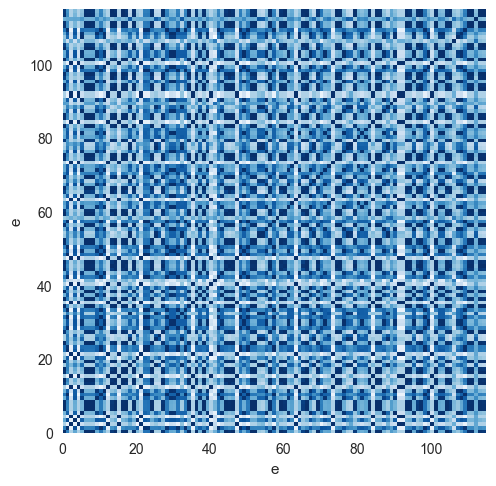

In [154]:
pcolor(D, cmap=PyPlot.PyPlot.cm_get_cmap("Blues"))
xlabel("e")
ylabel("e")
gca()[:set_aspect]("equal")

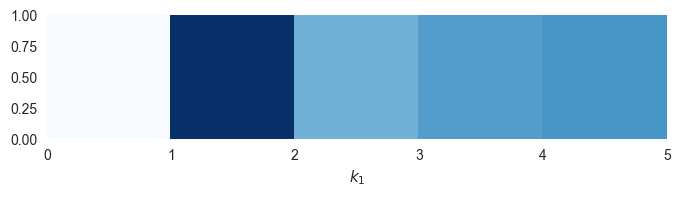

In [20]:
pcolor(reshape(hmm.π0, (1, hmm.K)), cmap=PyPlot.PyPlot.cm_get_cmap("Blues"))
xlabel(L"k_1")
gca()[:set_aspect]("equal")

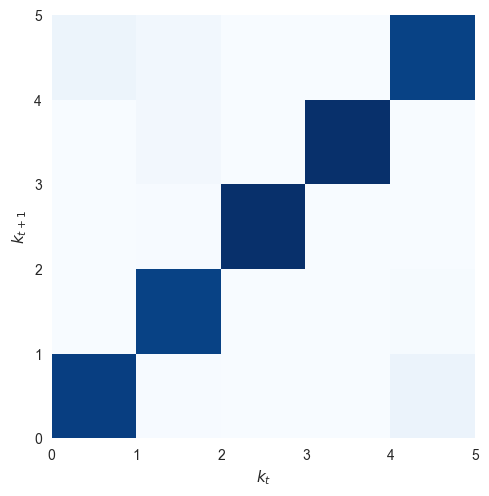

In [21]:
pcolor(hmm.A, cmap=PyPlot.PyPlot.cm_get_cmap("Blues"))
xlabel(L"k_t")
ylabel(L"k_{t+1}")
gca()[:set_aspect]("equal")

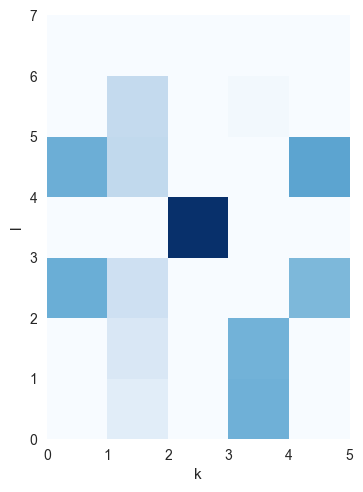

In [22]:
pcolor(hmm.bΔ, cmap=PyPlot.PyPlot.cm_get_cmap("Blues"))
xlabel("k")
ylabel("l")
gca()[:set_aspect]("equal")

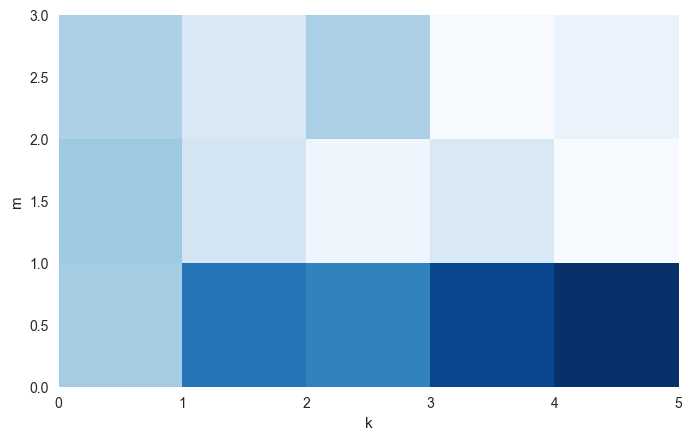

In [23]:
pcolor(hmm.c, cmap=PyPlot.PyPlot.cm_get_cmap("Blues"))
xlabel("k")
ylabel("m")
gca()[:set_aspect]("equal")

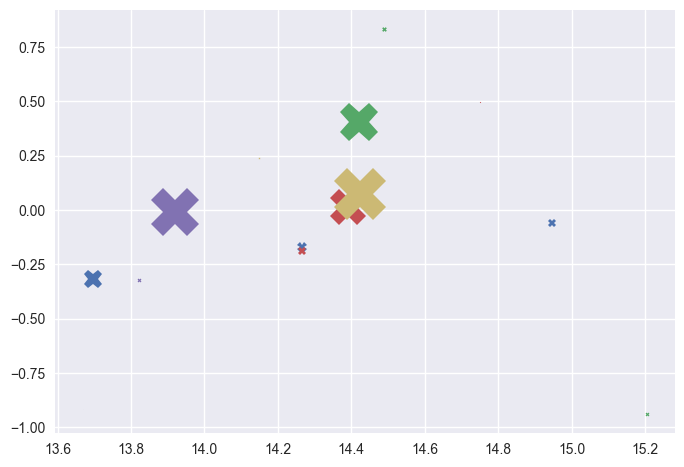

In [24]:
fig = figure()
ax = fig[:gca]()

for k in 1:hmm.K
    clr=0
    for m in 1:hmm.M
        if m == 1
            l = plot(hmm.μs[1, m, k], hmm.μs[2, m, k], "X", markersize=40*hmm.c[m, k])
            clr = l[1][:get_color]()
        else
            plot(hmm.μs[1, m, k], hmm.μs[2, m, k], "X", markersize=20*hmm.c[m, k], c=clr)
        end
    end
end
#legend(bbox_to_anchor=(1, 1))